In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import os
import time

In [3]:
import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect
from sqlalchemy import Column,Integer,String,Float,and_, Date, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite") 

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'measurements', 'station', 'stations']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#collect the start and end dates of the trips
trip_startdate = input ("Enter a start date of the trip in YYYY-MM-DD format:")
year,month,day = map(int,trip_startdate.split("-"))
start_date = datetime.date(year,month,day)

trip_enddate = input("Enter a end date for the trip in YYYY-MM-DD format:")
year,month,day = map(int,trip_enddate.split("-"))
end_date = datetime.date(year,month,day)

Enter a start date of the trip in YYYY-MM-DD format:2018-07-01
Enter a end date for the trip in YYYY-MM-DD format:2018-07-05


# Exploratory Climate Analysis

In [11]:
inspector=inspect(engine)
tables=inspector.get_table_names()
for table in tables:
    print (table)
    columns = inspector.get_columns(table)
    for c in columns:
        print(c['name'], c["type"]) 
    print("\n")

measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


measurements
station VARCHAR(255)
date TEXT
prcp FLOAT
tobs INTEGER


station
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


stations
station VARCHAR(255)
name VARCHAR(255)
latitude FLOAT
longtitude FLOAT
elevation FLOAT




In [12]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall() 

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [13]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# Total dates
session.query(func.count(Measurement.date)).all()

[(19550)]

In [15]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [16]:
# Latest Date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

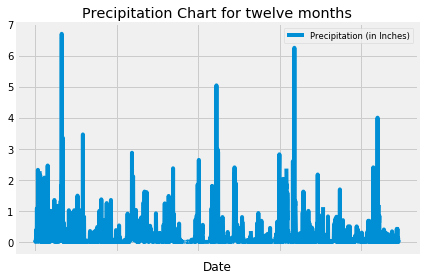

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from '2017-08-20'as the latest date is 2017-08-23

year_today = datetime.date(2017,8,20)
year_ago = year_today - datetime.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

yearly_data = session.query(Measurement.__table__).\
    filter(and_(Measurement.date >= year_ago, Measurement.date < year_today)).\
    order_by(Measurement.date).all()    

# Save the query results as a Pandas DataFrame and set the index to the date column
yearly_df = pd.DataFrame(yearly_data, columns = ['ID','Station #','Date','Precipitation (in Inches)',\
                                                 'Time of Observation Changes (TOBs)'])

yearly_df.set_index('Date', inplace= True)

# Use Pandas Plotting with Matplotlib to plot the data

yearly_df.plot(y='Precipitation (in Inches)', title="Precipitation Chart for twelve months", legend=True)

# Rotate the xticks for the dates
# to revisit to clean up, switch to plt from pandas plot
plt.legend(fontsize="small",loc="best")
plt.xticks(rotation = '45')
plt.tight_layout()
plt.show()

In [18]:
yearly_df.describe()

,ID,Precipitation (in Inches),Time of Observation Changes (TOBs)
count,2234.000000,2025.000000,2234.000000
mean,10155.715756,0.179896,74.585049
std,5597.881970,0.464338,4.600587
min,2361.000000,0.000000,58.000000
25%,5286.250000,0.000000,72.000000
50%,8930.500000,0.020000,75.000000
75%,14748.750000,0.130000,78.000000
max,19546.000000,6.700000,87.000000


Station Analysis
    Design a query to calculate the total number of stations.
    Design a query to find the most active stations.
        List the stations and observation counts in descending order
        Which station has the highest number of observations?
    Design a query to retrieve the last 12 months of temperature observation data (tobs).
        Filter by the station with the highest number of observations.
        Plot the results as a histogram with bins=12.

In [19]:
# How many stations are available in this dataset?
# Number of stations
stations = session.query(func.count(Station.station)).all()
print(f'There are {stations}stations available in this dataset')

There are [(9,)]stations available in this dataset


In [20]:
# What are the most active stations?
# List the stations and the counts in descending order.
# Most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Station with the highest no. of observations
active_stations[:1]

[('USC00519281', 2772)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_max_avg = session.query(func.min(Measurement.tobs),\
                            func.max(Measurement.tobs),\
                            func.avg(Measurement.tobs)).\
                            filter(Measurement.station == 'USC00519281').all()

print(min_max_avg)

[(54.0, 85.0, 71.66378066378067)]


Text(0.5,1,'')

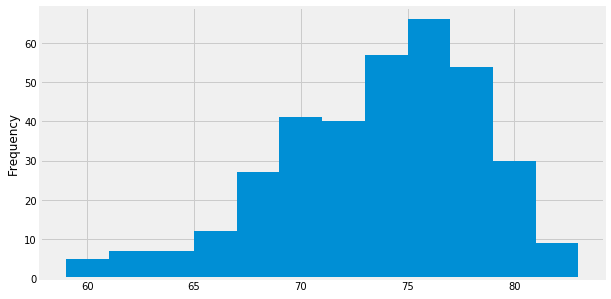

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
pop_station = session.query(Measurement.__table__).\
    filter(Measurement.station == 'USC00519281').\
    filter(and_(Measurement.date >= year_ago, Measurement.date < year_today)).all()
    
pop_station_df = pd.DataFrame(pop_station, columns = ['ID','Station #','Date','Precipitation (in Inches)',\
                                                 'Temperature'])

pop_station_df.set_index('Date', inplace= True)
pop_station_df.hist('Temperature', bins=12,figsize=(9,5))
plt.ylabel('Frequency')
plt.title('',size=15)

In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps (stt_dt, end_dt):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),
                        func.max(Measurement.tobs)).filter(Measurement.date > stt_dt).\
            filter(Measurement.date <= end_dt).all()

min_avg_max_temp = calc_temps('2017-02-28', '2017-03-05')
min_avg_max_temp

[(64.0, 71.96551724137932, 78.0)]

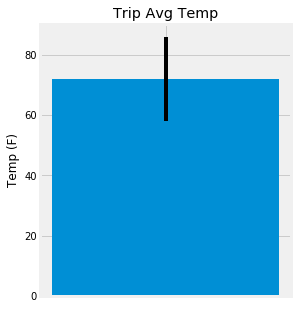

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
def calc_temps(start_date, end_date):
    tripdates = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= start_date,\
         Measurement.date <= end_date).all()
    tripdates_df = pd.DataFrame(tripdates)
    max_temp = tripdates_df["tobs"].max()
    min_temp = tripdates_df["tobs"].min()
    mean_temp = tripdates_df["tobs"].mean()
    plt.figure(figsize=(4,5))
    plt.bar(1,mean_temp, yerr= max_temp - min_temp, tick_label="")
    plt.title('Trip Avg Temp')
    plt.ylabel('Temp (F)')
    plt.show()
calc_temps("2017-02-28", "2017-03-05")